(recorders_vignette)=

# Recording data during a simulation

In order to facilitate time-series analyses, you may pass a callable object to {meth}`fwdpy11.evolvets`.
The following boiler plate illustrates the requirements for the callable objects in both `Python` and in `C++`:

```{tabbed} python

:::{code-block} python
class Recorder(object):
    def __call__(self, pop: fwdpy11.DiploidPopulation, sampler: fwdpy11.SampleRecorder):
        pass
:::
```

```{tabbed} c++

:::{code-block} c++
#include <fwdpy11/evolvets/SampleRecorder.hpp>
#include <fwdpy11/types/DiploidPopulation.hpp>

struct Recorder {
    void operator()(const fwdpy11::DiploidPopulation & pop,
                    const fwdpy11::SampleRecorder & sampler)
    {
    }
};
:::
```

The remainder of this vignette will only cover `Python`.
The arguments to `__call__` are an instance of {class}`fwdpy11.DiploidPopulation` and {class}`fwdpy11.SampleRecorder`, respectively.
The latter allows one to record "ancient samples" during a simulation, which we discuss more below.

:::{note}
Given that you can pass in any valid Python object, you can record anything you can imagine based on attributes of {class}`fwdpy11.DiploidPopulation`.
Further, as many of those attributes can be viewed as {class}`numpy.ndarray` or {class}`numpy.recarray`, you may use any Python library compatible with those types.

You can also process the genealogy of the population.
Doing so is an advanced topic, which we deal with in a later vignette.
:::

:::{todo}
Write vignette showing how to access the tree sequences during a simulation.
:::

Let's return to the model from the previous vignette.
We will implement a recorder to track the mean trait value and fitness of the entire population over time.

That recorder object will look like this:

In [1]:
import fwdpy11
import numpy as np

class Recorder(object):
    def __init__(self):
        self.generation = []
        self.mean_trait_value = []
        self.mean_fitness = []
        
    def __call__(self, pop, sampler):
        md = np.array(pop.diploid_metadata, copy=False)
        self.generation.append(pop.generation)
        self.mean_trait_value.append(md['g'].mean())
        self.mean_fitness.append(md['w'].mean())

The details of the simulation model follow, but are hidden by default as they repeat material from the previous vignette.

In [2]:
pop = fwdpy11.DiploidPopulation(500, 1.0)

rng = fwdpy11.GSLrng(54321)

GSSmo = fwdpy11.GSSmo(
    [
        fwdpy11.Optimum(when=0, optimum=0.0, VS=1.0),
        fwdpy11.Optimum(when=pop.N, optimum=1.0, VS=1.0),
    ]
)

rho = 1000.

des = fwdpy11.GaussianS(beg=0, end=1, weight=1, sd=0.1,
    h=fwdpy11.LargeEffectExponentiallyRecessive(k=5.0))

p = {
    "nregions": [],
    "gvalue": fwdpy11.Additive(2.0, GSSmo),
    "sregions": [des],
    "recregions": [fwdpy11.PoissonInterval(0, 1., rho / float(4 * pop.N))],
    "rates": (0.0, 1e-3, None),
    "prune_selected": False,
    "demography": fwdpy11.DiscreteDemography(),
    "simlen": pop.N + 200,
}
params = fwdpy11.ModelParams(**p)

We now pass in our callable to {meth}`fwdpy11.evolvets`:

In [3]:
recorder = Recorder()
fwdpy11.evolvets(rng, pop, params, recorder=recorder, simplification_interval=100) 

Plotting our results:

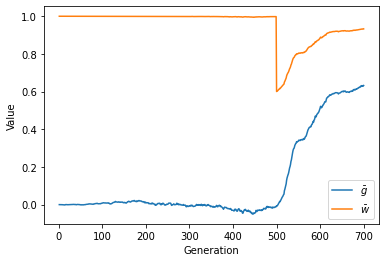

In [4]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()
ax.plot(recorder.generation, recorder.mean_trait_value, label=r'$\bar{g}$')
ax.plot(recorder.generation, recorder.mean_fitness, label=r'$\bar{w}$')
ax.set_xlabel('Generation')
ax.set_ylabel('Value')
ax.legend(loc='best');

(ancient_samples_vignette)=

## Recording ancient samples

Let's write a new class that "preserves" a random number of individuals each generation.
This recording preserves their nodes in the {class}`fwdpy11.TableCollection` and their meta data in {attr}`fwdpy11.DiploidPopulation.ancient_sample_metadata`.

Our class will also do all of the same operations that `Recorder` did.

In [5]:
class RandomSamples(object):
    def __init__(self, nsam):
        self.nsam = nsam
        self.generation = []
        self.mean_trait_value = []
        self.mean_fitness = []
        
    def __call__(self, pop, sampler):
        md = np.array(pop.diploid_metadata, copy=False)
        self.generation.append(pop.generation)
        self.mean_trait_value.append(md['g'].mean())
        self.mean_fitness.append(md['w'].mean())
        sampler.assign(np.random.choice(pop.N, self.nsam, replace=False))

To run this, we first create a new population, random number generator, and model parameters object.
We need a new model parameters instance because the one used above has already applied the optimum shift.
Thus, we need to rebuild the `gvalue` field.

In [6]:
import pickle
pop = fwdpy11.DiploidPopulation(500, 1.0)
rng = fwdpy11.GSLrng(54321)
p['gvalue'] = fwdpy11.Additive(2.0, GSSmo)
params = fwdpy11.ModelParams(**p)
recorder = RandomSamples(5)
fwdpy11.evolvets(rng, pop, params, recorder=recorder, simplification_interval=100) 

We now want to recreate the plot from above, but with the values from our ancient samples shown as dots.
Analyzing each time point separately is a common operation made easier by {meth}`fwdpy11.DiploidPopulation.sample_timepoints`.

In [7]:
ancient_generation = []
ancient_mean_trait_value = []
ancient_mean_fitness = []
for g, nodes, md in pop.sample_timepoints(include_alive=False):
    ancient_generation.append(g)
    ancient_mean_trait_value.append(md['g'].mean())
    ancient_mean_fitness.append(md['w'].mean())

Finally, the plot:

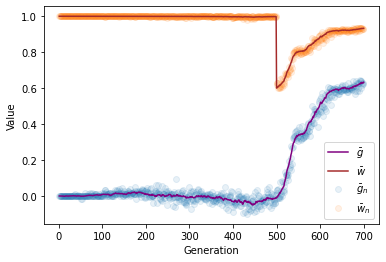

In [8]:
f, ax = plt.subplots()
ax.scatter(ancient_generation, ancient_mean_trait_value,
           alpha=0.1, label=r'$\bar{g}_{n}$')
ax.scatter(ancient_generation, ancient_mean_fitness,
           alpha=0.1, label=r'$\bar{w}_{n}$')
ax.plot(recorder.generation, recorder.mean_trait_value,
        color='purple',
        alpha=1, label=r'$\bar{g}$')
ax.plot(recorder.generation, recorder.mean_fitness,
        color='brown',
        alpha=1, label=r'$\bar{w}$')
ax.set_xlabel('Generation')
ax.set_ylabel('Value')
ax.legend(loc='best');

### Built-in ancient sample recorders

* {class}`fwdpy11.RandomAncientSamples`